In [1]:
import math
import os
import torch
import torchvision
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [2]:
df=pd.read_csv("TSLA.csv")
print('Number of rows and columns:', df.shape)
df

Number of rows and columns: (1259, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-07-10,52.444000,52.599998,51.563999,51.830002,51.830002,13054500
1,2015-07-13,52.450001,52.509998,51.209999,52.431999,52.431999,14801500
2,2015-07-14,52.419998,53.198002,52.102001,53.130001,53.130001,9538000
3,2015-07-15,53.348000,53.498001,52.416000,52.627998,52.627998,10108000
4,2015-07-16,52.844002,53.439999,52.632000,53.335999,53.335999,8080000
...,...,...,...,...,...,...,...
1254,2020-07-02,244.296005,245.600006,237.119995,241.731995,241.731995,86250500
1255,2020-07-06,255.337997,275.558014,253.207993,274.316010,274.316010,102849500
1256,2020-07-07,281.002014,285.899994,267.342010,277.971985,277.971985,107448500
1257,2020-07-08,281.000000,283.451996,262.268005,273.175995,273.175995,81556500


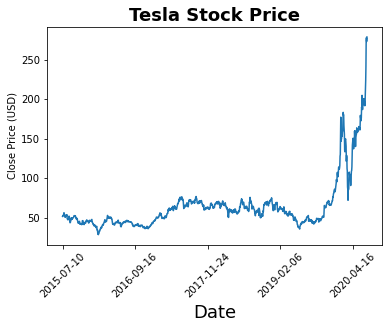

In [3]:
plt.plot(df[['Close']])
plt.xticks(range(0,df.shape[0],300),df['Date'].loc[::300],rotation=45)
plt.title("Tesla Stock Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)')
plt.show()

In [4]:
# 80% training and 20% testing
training_set = df.iloc[:1000, 4:5].values
test_set = df.iloc[1000:, 4:5].values

In [5]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [6]:
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 1000):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))



In [7]:
# Getting the predicted stock price of 2020

dataset_train = df.iloc[:1000, 4:5]
dataset_test = df.iloc[1000:, 4:5]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)


inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values

inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 1259-1000+60):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)
# (259, 60, 1)

(259, 60, 1)


In [8]:
X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)

X_train = X_train.cuda()
X_test = X_test.cuda()
y_train_lstm = y_train_lstm.cuda()


In [9]:
import torch
import torch.nn as nn

# hyperparameters
input_dim = 1
hidden_dim = 60 # 60 neurons
num_layers = 4 # 4 layers
output_dim = 1
num_epochs = 100

In [10]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim,droprate):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, dropout = droprate, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().cuda()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().cuda()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [15]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers,droprate = 0.2)
model.cuda()

criterion = torch.nn.MSELoss() #mse loss function
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)   # adam optimizer


In [16]:
hist = np.zeros(num_epochs)
lstm = []
    
for t in range(num_epochs): 
    torch.manual_seed(0)
    y_train_pred = model(X_train)
    loss = criterion(y_train_pred, y_train_lstm)
    if t%10 == 0 :
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
print("Epoch ", t, "MSE: ", loss.item())

Epoch  0 MSE:  0.4282144606113434
Epoch  10 MSE:  0.0620485320687294
Epoch  20 MSE:  0.057860758155584335
Epoch  30 MSE:  0.03174809738993645
Epoch  40 MSE:  0.01313750259578228
Epoch  50 MSE:  0.00637309392914176
Epoch  60 MSE:  0.005183547269552946
Epoch  70 MSE:  0.004489440005272627
Epoch  80 MSE:  0.0037097539752721786
Epoch  90 MSE:  0.003388639073818922
Epoch  99 MSE:  0.003254661103710532


In [17]:
model = model.eval()
predicted_stock_price = model(X_test)

predicted_stock_price = predicted_stock_price.cpu()
predicted_stock_price1 = sc.inverse_transform(predicted_stock_price.detach().numpy())

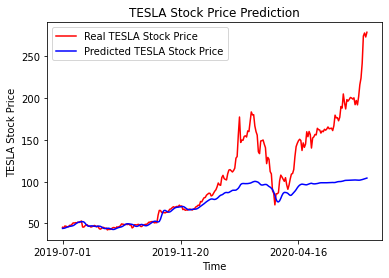

In [18]:
# Visualising the results
plt.plot(df.loc[1000:, 'Date'],dataset_test.values, color = 'red', label = 'Real TESLA Stock Price')
plt.plot(df.loc[1000:, 'Date'],predicted_stock_price1, color = 'blue', label = 'Predicted TESLA Stock Price')
plt.xticks(np.arange(0,300,100))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()

# Using 7-day lag

In [19]:
# Creating a data structure with 60 time-steps with 7-day lag and 1 output
X_train = []
y_train = []
for i in range(60, 1000-6):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i+6, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))
print(X_train.shape)
#(934, 60, 1)

(934, 60, 1)


In [20]:
# Getting the predicted stock price of 2020

dataset_train = df.iloc[:1000-6, 4:5]
dataset_test = df.iloc[1000-6:, 4:5]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)


inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values

inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 1259-1000+60):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)
# (259, 60, 1)

(259, 60, 1)


In [21]:
X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)

X_train = X_train.cuda()
X_test = X_test.cuda()
y_train_lstm = y_train_lstm.cuda()

In [22]:
model1 = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers,droprate = 0.2)
model1.cuda()

criterion = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model1.parameters(), lr=0.01)

In [23]:
hist = np.zeros(num_epochs)
lstm = []
torch.manual_seed(0)

for t in range(num_epochs):
    model1.train()
    y_train_pred = model1(X_train)
    
    loss = criterion(y_train_pred, y_train_lstm)
    if t%10 == 0 :
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
print("Epoch ", t, "MSE: ", loss.item())

Epoch  0 MSE:  0.4298517107963562
Epoch  10 MSE:  0.06770633161067963
Epoch  20 MSE:  0.057545918971300125
Epoch  30 MSE:  0.032778069376945496
Epoch  40 MSE:  0.011045243591070175
Epoch  50 MSE:  0.009931142441928387
Epoch  60 MSE:  0.00972677767276764
Epoch  70 MSE:  0.009276706725358963
Epoch  80 MSE:  0.009034091606736183
Epoch  90 MSE:  0.008856195025146008
Epoch  99 MSE:  0.00864365603774786


In [24]:
model1 = model1.eval()
predicted_stock_price = model1(X_test)

predicted_stock_price = predicted_stock_price.cpu()
predicted_stock_price = sc.inverse_transform(predicted_stock_price.detach().numpy())

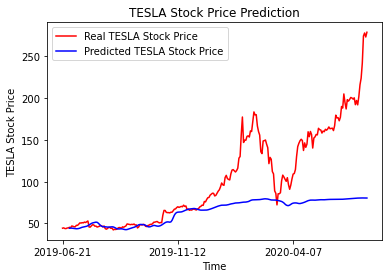

In [25]:
# Visualising the results
plt.plot(df.loc[1000-6:, 'Date'],dataset_test.values, color = 'red', label = 'Real TESLA Stock Price')
plt.plot(df.loc[1000:, 'Date'],predicted_stock_price, color = 'blue', label = 'Predicted TESLA Stock Price')
plt.xticks(np.arange(0,300,100))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()

We see that the results are worse by lagging the date by 7 as the MSE increases. 

# Using 14-day lag

In [26]:
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 1000-13):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i+13, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))


# Getting the predicted stock price of 2020

dataset_train = df.iloc[:1000-13, 4:5]
dataset_test = df.iloc[1000-13:, 4:5]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)


inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values

inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 1259-1000+60):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)
# (259, 60, 1)

(259, 60, 1)


In [27]:
X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)

X_train = X_train.cuda()
X_test = X_test.cuda()
y_train_lstm = y_train_lstm.cuda()

In [28]:
model2 = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers,droprate = 0.2)
model2.cuda()

criterion = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model2.parameters(), lr=0.01)

In [29]:
hist = np.zeros(num_epochs)
lstm = []
torch.manual_seed(0)

for t in range(num_epochs):
    y_train_pred = model2(X_train)
    
    loss = criterion(y_train_pred, y_train_lstm)
    if t%10 == 0 :
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    loss.backward()
    optimiser.step()
    optimiser.zero_grad()
print("Epoch ", t, "MSE: ", loss.item())

Epoch  0 MSE:  0.432029664516449
Epoch  10 MSE:  0.06366360187530518
Epoch  20 MSE:  0.05890260264277458
Epoch  30 MSE:  0.04301665723323822
Epoch  40 MSE:  0.018216479569673538
Epoch  50 MSE:  0.015051139518618584
Epoch  60 MSE:  0.013953314162790775
Epoch  70 MSE:  0.013630320318043232
Epoch  80 MSE:  0.013195855543017387
Epoch  90 MSE:  0.012655461207032204
Epoch  99 MSE:  0.012668429873883724


In [30]:
model2.eval()
predicted_stock_price = model2(X_test)

predicted_stock_price = predicted_stock_price.cpu()
predicted_stock_price = sc.inverse_transform(predicted_stock_price.detach().numpy())

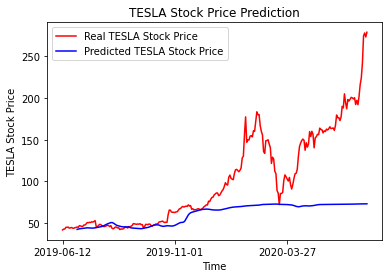

In [31]:
# Visualising the results
plt.plot(df.loc[1000-13:, 'Date'],dataset_test.values, color = 'red', label = 'Real TESLA Stock Price')
plt.plot(df.loc[1000:, 'Date'],predicted_stock_price, color = 'blue', label = 'Predicted TESLA Stock Price')
plt.xticks(np.arange(0,300,100))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()

We see that the results are worse by lagging the date by 14 as the MSE increases. Therefore，the original model with lag = 1 day is prefered.  

# using different hyperparameters

We use data with 1-day lag because it produces the best output.

First, we compare the results of using 4 and 6 hidden layers, holding all other hyperparameters constant

In [32]:
# hyperparameters
input_dim = 1
hidden_dim = 60 # 60 neurons
num_layers = 6 # 6 layers
output_dim = 1
num_epochs = 100

In [33]:
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 1000):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

# Getting the predicted stock price of 2020

dataset_train = df.iloc[:1000, 4:5]
dataset_test = df.iloc[1000:, 4:5]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)


inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values

inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 1259-1000+60):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)

X_train = X_train.cuda()
X_test = X_test.cuda()
y_train_lstm = y_train_lstm.cuda()

In [46]:
model3 = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers,droprate = 0.2)
model3.cuda()

criterion = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model3.parameters(), lr=0.01)

In [47]:
hist = np.zeros(num_epochs)
lstm = []
torch.manual_seed(0)

for t in range(num_epochs): 
    y_train_pred = model3(X_train)
    loss = criterion(y_train_pred, y_train_lstm)
    if t%10 == 0 :
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
print("Epoch ", t, "MSE: ", loss.item())

Epoch  0 MSE:  0.26199811697006226
Epoch  10 MSE:  0.05613972991704941
Epoch  20 MSE:  0.056207671761512756
Epoch  30 MSE:  0.05599557235836983
Epoch  40 MSE:  0.05570382997393608
Epoch  50 MSE:  0.052133575081825256
Epoch  60 MSE:  0.019479045644402504
Epoch  70 MSE:  0.009762240573763847
Epoch  80 MSE:  0.006017046514898539
Epoch  90 MSE:  0.004475974943488836
Epoch  99 MSE:  0.0037277271039783955


In [48]:
model3 = model3.eval()
predicted_stock_price = model3(X_test)

predicted_stock_price = predicted_stock_price.cpu()
predicted_stock_price = sc.inverse_transform(predicted_stock_price.detach().numpy())

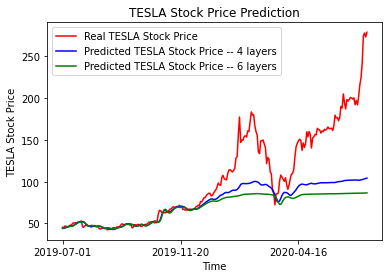

In [49]:
# Visualising the results
plt.plot(df.loc[1000:, 'Date'],dataset_test.values, color = 'red', label = 'Real TESLA Stock Price')
plt.plot(df.loc[1000:, 'Date'],predicted_stock_price1, color = 'blue', label = 'Predicted TESLA Stock Price -- 4 layers')
plt.plot(df.loc[1000:, 'Date'],predicted_stock_price, color = 'green', label = 'Predicted TESLA Stock Price -- 6 layers')
plt.xticks(np.arange(0,300,100))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()

# Result: 4 hidden layers seems to be the better choice since it has lower MSE. 

Second, we compare the results of a drop out rate of 0.2 and 0.5, holding all other hyperparamters constant 

In [50]:
# hyperparameters
input_dim = 1
hidden_dim = 60 # 60 neurons
num_layers = 6 # 4 layers
output_dim = 1
num_epochs = 100

In [51]:
model4 = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers,droprate = 0.5)
model4.cuda()

criterion = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model4.parameters(), lr=0.01)


In [52]:
hist = np.zeros(num_epochs)
lstm = []

for t in range(num_epochs): 
    y_train_pred = model4(X_train)
    loss = criterion(y_train_pred, y_train_lstm)
    if t%10 == 0 :
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
print("Epoch ", t, "MSE: ", loss.item())

Epoch  0 MSE:  0.26174691319465637
Epoch  10 MSE:  0.05760493129491806
Epoch  20 MSE:  0.05660923197865486
Epoch  30 MSE:  0.05602937191724777
Epoch  40 MSE:  0.05591210350394249
Epoch  50 MSE:  0.05543959513306618
Epoch  60 MSE:  0.04783167690038681
Epoch  70 MSE:  0.03226060792803764
Epoch  80 MSE:  0.015007324516773224
Epoch  90 MSE:  0.011270605027675629
Epoch  99 MSE:  0.007373714819550514


In [53]:
model4 = model4.eval()
predicted_stock_price = model4(X_test)

predicted_stock_price = predicted_stock_price.cpu()
predicted_stock_price = sc.inverse_transform(predicted_stock_price.detach().numpy())

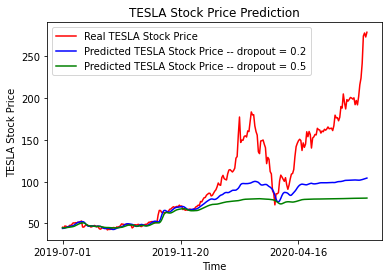

In [54]:
# Visualising the results
plt.plot(df.loc[1000:, 'Date'],dataset_test.values, color = 'red', label = 'Real TESLA Stock Price')
plt.plot(df.loc[1000:, 'Date'],predicted_stock_price1, color = 'blue', label = 'Predicted TESLA Stock Price -- dropout = 0.2')
plt.plot(df.loc[1000:, 'Date'],predicted_stock_price, color = 'green', label = 'Predicted TESLA Stock Price -- dropout = 0.5')
plt.xticks(np.arange(0,300,100))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()

# Result: dropout rate of 0.2 is a better choice since it has lower MSE. 

# Predict the stock price for the next two weeks

In [55]:
# get the last date
dates = df['Date']
dates[len(dates)-1]

'2020-07-09'

In [56]:
first_day = '2020-07-10'
last_day = '2020-07-23'

In [57]:
date_list = pd.date_range(start= first_day,end=last_day)

In [58]:
date_list = [i.strftime("%Y-%m-%d") for i in date_list]

In [59]:
date_list

['2020-07-10',
 '2020-07-11',
 '2020-07-12',
 '2020-07-13',
 '2020-07-14',
 '2020-07-15',
 '2020-07-16',
 '2020-07-17',
 '2020-07-18',
 '2020-07-19',
 '2020-07-20',
 '2020-07-21',
 '2020-07-22',
 '2020-07-23']

In [60]:
indexes = [1,2,8,9]
for ind in sorted(indexes, reverse=True):
    del date_list[ind]

In [61]:
date_list

['2020-07-10',
 '2020-07-13',
 '2020-07-14',
 '2020-07-15',
 '2020-07-16',
 '2020-07-17',
 '2020-07-20',
 '2020-07-21',
 '2020-07-22',
 '2020-07-23']

The model is using 10-day lag since there are 10 days to predict.

In [62]:
sc = MinMaxScaler(feature_range = (0, 1))

training_set = df.iloc[:1259, 4:5].values
test_set = df.iloc[1259:, 4:5].values
training_set_scaled = sc.fit_transform(training_set)

In [63]:
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 1259-9):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i+9, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

# Getting the predicted stock price of 2020

dataset_train = df.iloc[:1259-9, 4:5]
dataset_test = df.iloc[1259-9:, 4:5]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)


inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values

inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 10+60):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)
# (10, 60, 1)

(10, 60, 1)


In [64]:
X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)

X_train = X_train.cuda()
X_test = X_test.cuda()
y_train_lstm = y_train_lstm.cuda()

In [65]:
# hyperparameters
input_dim = 1
hidden_dim = 60 # 60 neurons
num_layers = 4 # 4 layers
output_dim = 1
num_epochs = 100

In [66]:
model5 = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers,droprate = 0.2)
model5.cuda()

criterion = torch.nn.MSELoss() #mse loss function
optimiser = torch.optim.Adam(model5.parameters(), lr=0.01)   # adam optimizer

In [67]:
hist = np.zeros(num_epochs)
lstm = []

for t in range(num_epochs): 
    y_train_pred = model5(X_train)
    loss = criterion(y_train_pred, y_train_lstm)
    if t%10 == 0 :
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
print("Epoch ", t, "MSE: ", loss.item())

Epoch  0 MSE:  0.08058299124240875
Epoch  10 MSE:  0.018926937133073807
Epoch  20 MSE:  0.018227707594633102
Epoch  30 MSE:  0.015528974123299122
Epoch  40 MSE:  0.006217013578861952
Epoch  50 MSE:  0.003360681002959609
Epoch  60 MSE:  0.0027897367253899574
Epoch  70 MSE:  0.0023492928594350815
Epoch  80 MSE:  0.0020478966180235147
Epoch  90 MSE:  0.0022423395421355963
Epoch  99 MSE:  0.0016980621730908751


In [68]:
model5 = model5.eval()
predicted_stock_price = model5(X_test)

predicted_stock_price = predicted_stock_price.cpu()
predicted_stock_price = sc.inverse_transform(predicted_stock_price.detach().numpy())

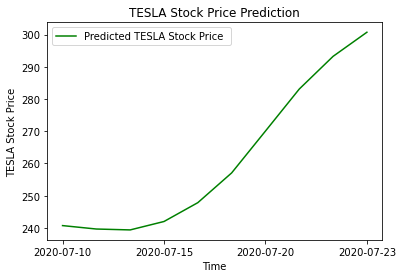

In [69]:
# Visualising the results
plt.plot(date_list,predicted_stock_price, color = 'green', label = 'Predicted TESLA Stock Price ')
plt.xticks(np.arange(0,10,3))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()

The actual price of Tesla stock on 2020-7-10 is 279.20 and on 2020-7-23 is 335.79. Therefore, the model is pretty accurate. However, I am using the entire data minus the last 10 days as the training set since the model will not perform very well when I do not include data that are recent, as seen from previous examples. 